## Exercise 2A: Financial timeseries

Exercise based on Chapter 2 of the book *Advances in Financial Machine Learning* by Marcos Lopez de Prado.

In this exercise we will learn to work with financial timeseries and the different methods of sampling the price of a security over time. Go through the notebook and answer the questions presented. Most of the code is provided for you, as the objective is to gain an intuition of the quirks of financial data. You are, however, encouraged to play around with other parts of the code and data to gain a deeper understanding.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import normaltest, shapiro

In [36]:
# How many bars are we sampling using each of the methods?
num_bars = 100000

# If True, save the consturcted bars to csv.
# You might want to set this to False when changing the number of bars above.
save_data = True

## Loading the tick data

Let's start by reading the raw data from the provided csv-file.

In [37]:
df = pd.read_csv('./data/sp500.csv')
df.head()

,date,time,price,volume
0,01/03/2010,17:00:00.000,1113.2,1.0
1,01/03/2010,17:00:00.000,1113.2,1.0
2,01/03/2010,17:00:00.000,1113.2,1.0
3,01/03/2010,17:00:00.000,1113.2,1.0
4,01/03/2010,17:00:00.000,1113.2,1.0


In [38]:
df.shape[0]

381260

Date and time are provided in different columns. Working with the data is easier if these are both combined into a datetime object that is then used as the index.

In [39]:
df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%m/%d/%Y%H:%M:%S.%f')
df.index = df['datetime']
df = df[['price', 'volume']]

df.head()

,price,volume
datetime,,
2010-01-03 17:00:00,1113.2,1.0
2010-01-03 17:00:00,1113.2,1.0
2010-01-03 17:00:00,1113.2,1.0
2010-01-03 17:00:00,1113.2,1.0
2010-01-03 17:00:00,1113.2,1.0


For sampling dollar bars we will need the total dollar amount exchanged in each transaction. A new column for this is easily added now.

In [40]:
df['dollar_volume'] = df['price'].mul(df['volume'])
df.head()

,price,volume,dollar_volume
datetime,,,
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2


Looking at basic descriptive statistics and plotting the data is a good way to gain a basic understanding of what we're working with.

In [41]:
df.describe()

,price,volume,dollar_volume
count,381259.000000,381259.000000,381259.000000
mean,1134.373143,0.886780,1005.964192
std,42.285504,1.272455,1437.884169
min,1041.000000,0.000000,0.000000
25%,1098.500000,0.000000,0.000000
50%,1135.300000,1.000000,1106.000000
75%,1167.500000,1.000000,1165.300000
max,1216.700000,141.000000,153520.800000


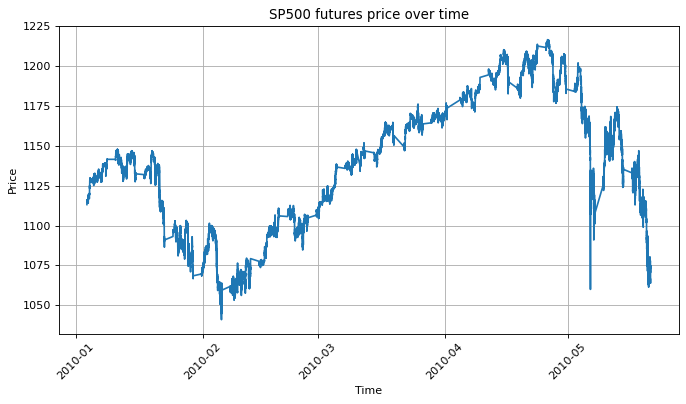

In [42]:
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(df.index, df['price'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('SP500 futures price over time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Tick bars

Let us now consturct the different bars described in chapter 2 of the book. For tick bars we sample the price each time a specified number of ticks takes place. Since our original data is tick data we may simply select every nth row to achieve this.

In [43]:
tick_threshold = df['volume'].count() // num_bars
tick_bars = df.iloc[::tick_threshold, :]
if save_data:
    tick_bars['price'].to_csv('./data/tick_bars.csv')
tick_bars.head()

,price,volume,dollar_volume
datetime,,,
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,2.0,2226.4


## Volume bars

For volume bars we sample the price each time a specified number of the security has been traded. We can achieve this by calculating a cumulative sum of volumes and selecting the rows where the sum first exceeds a multiple of the threshold.

In [44]:
volume_threshold = df['volume'].sum() / num_bars
volume_bars = df[~df['volume'].cumsum().floordiv(volume_threshold).duplicated()]
if save_data:
    volume_bars.to_csv('./data/volume_bars.csv')
volume_bars.head()

,price,volume,dollar_volume
datetime,,,
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,2.0,2226.4


## Dollar bars

Dollar bars are quite similar to volume bars, except that we work with traded dollar amounts, instead of security amounts.

In [45]:
dollar_threshold = df['dollar_volume'].sum() / num_bars
dollar_bars = df[~df['dollar_volume'].cumsum().floordiv(dollar_threshold).duplicated()]

if save_data:
    dollar_bars.to_csv('./data/dollar_bars.csv')
dollar_bars.head()

,price,volume,dollar_volume
datetime,,,
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:00:00,1113.2,2.0,2226.4


## Plotting

Having constructed the different bars, we can visualize them by plotting dots on the timeseries where a bar was sampled. The code below creates three plots, one for each of the different sampling methods.

In [46]:
# We can plot the data of a specific year,
#plot_date = '2010'

# a specific month,
#plot_date = '2010-06'

# a specific day,
#plot_date = '2010-06-01'

# or even of a specific hour
plot_date = '2010-01-06 03'

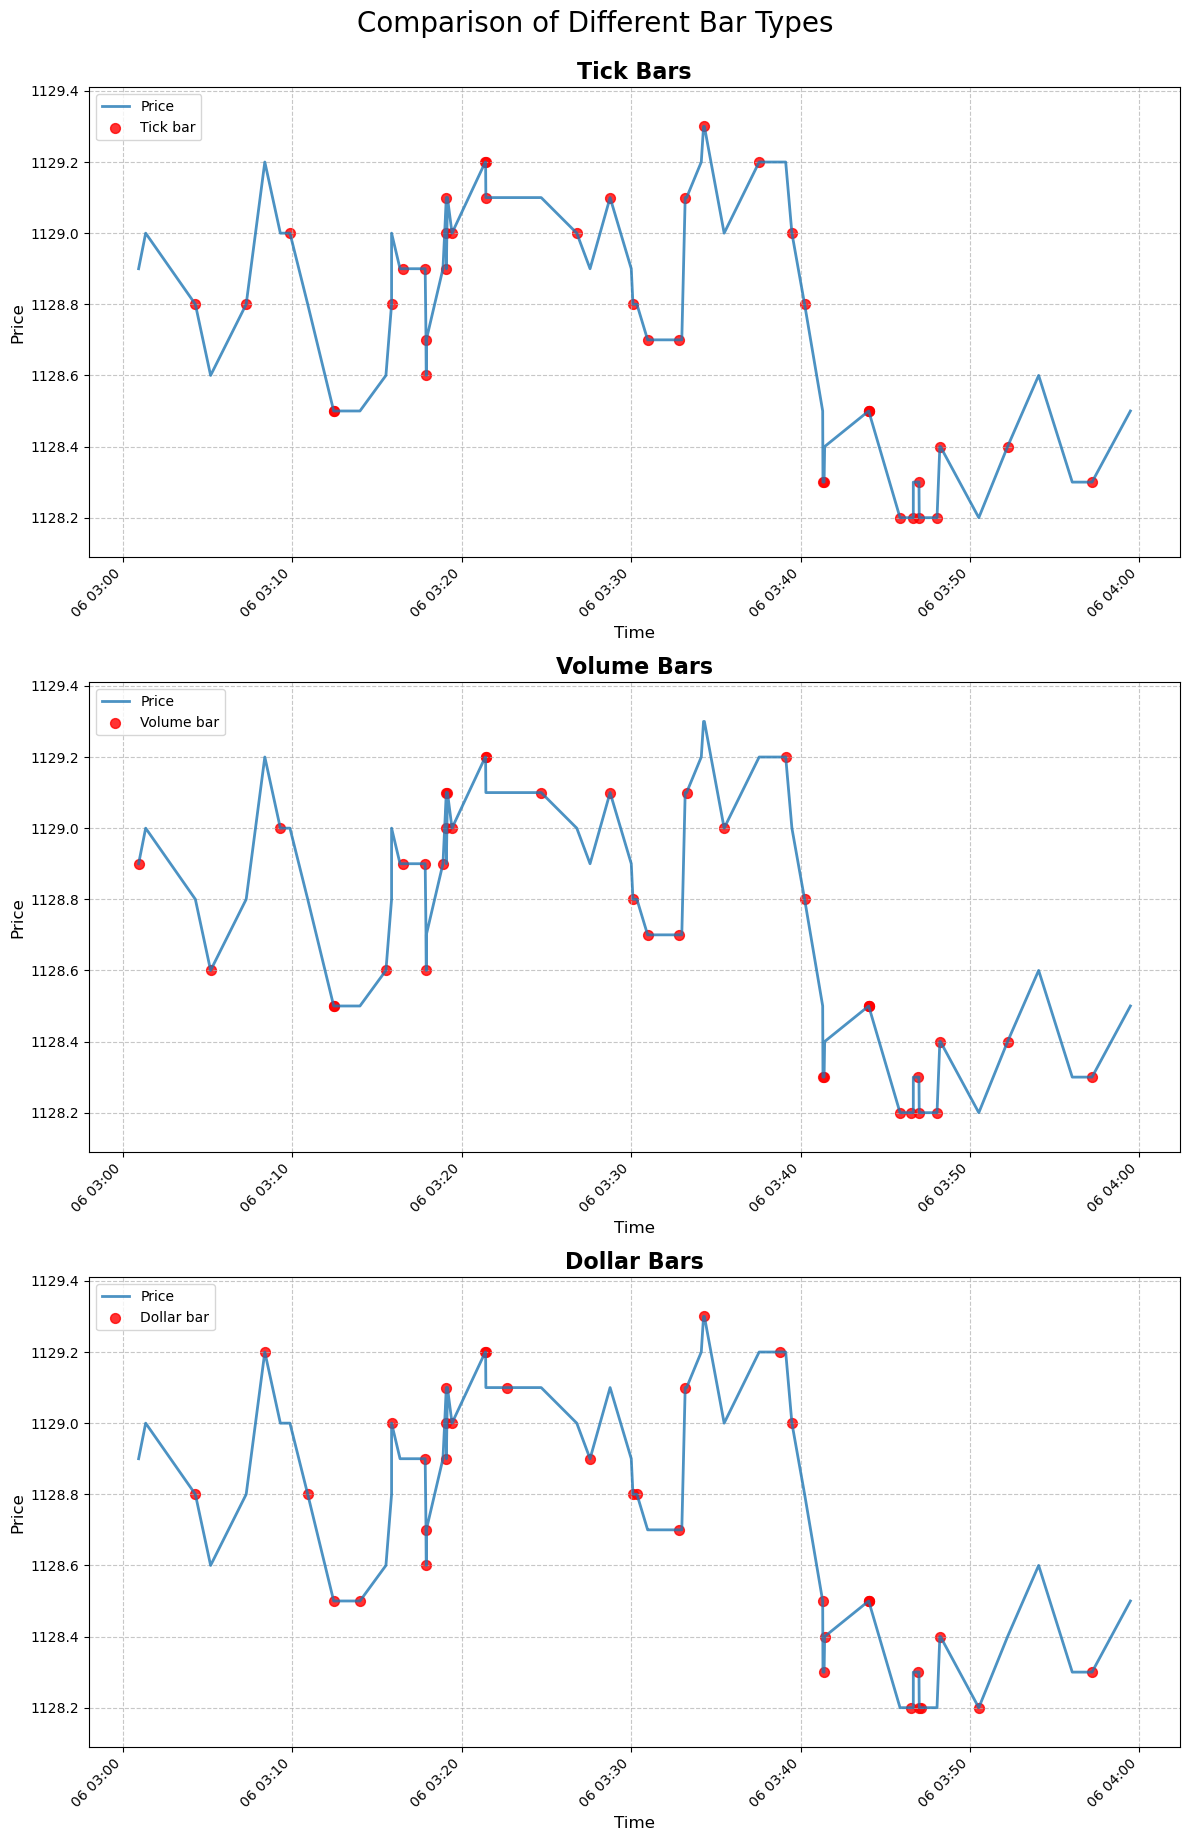

In [47]:
fig, axs = plt.subplots(3, figsize=(12, 18), dpi=100)

plot_slice = df.loc[plot_date]
series_slices = [series.loc[plot_date]['price'] for series in [tick_bars, volume_bars, dollar_bars]]

for i, (ax, series, title) in enumerate(zip(axs, series_slices, ['Tick', 'Volume', 'Dollar'])):
    # Plot the continuous price line
    ax.plot(plot_slice.index, plot_slice['price'], alpha=0.8, label='Price', linewidth=2)
    
    # Plot the bar points
    ax.scatter(series.index, series, color='red', alpha=0.8, marker='o', s=50, label=f'{title} bar')
    
    # Set title and labels
    ax.set_title(f'{title} Bars', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    
    # Rotate and align the tick labels so they look better
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Adjust y-axis to have some padding
    ax.margins(y=0.1)

# Adjust layout and add main title
plt.tight_layout()
fig.suptitle('Comparison of Different Bar Types', fontsize=20, y=1.02)

# Show plot
plt.show()


## <u>Task 1</u>

Run the two cells above with different choices of *plot_date* (examples on how to do this are in the cell). Try to find and view where you can spot similarities and/or differences between the sampling methods. Analyze this view.

Try to answer at least the following:

1) What are the similarities and differences between the different sampling methods?

2) What market conditions might explain said similarities/differences? (eg. under what conditions do all methods produce many bars)


**NOTE:** If you end up choosing a smaller time window you might need to increase the number of sampled bars in order to achieve a fitting bar density. You can do this by changing the value of *num_bars* (in the very first cell after imports) and running all cells below it.

## Bar counts

For further comparison between the sampling methods we may look at the amount of bars produced on a weekly basis.

In [48]:
tick_bar_counts = tick_bars['price'].groupby(pd.Grouper(freq="1W")).count()
volume_bar_counts = volume_bars['price'].groupby(pd.Grouper(freq="1W")).count()
dollar_bar_counts = dollar_bars['price'].groupby(pd.Grouper(freq="1W")).count()

In [49]:
tick_bar_counts

datetime
2010-01-03       88
2010-01-10     4306
2010-01-17     4737
2010-01-24     6415
2010-01-31     7560
2010-02-07     8612
2010-02-14     7554
2010-02-21     5448
2010-02-28     5533
2010-03-07     5329
2010-03-14     3322
2010-03-21     3519
2010-03-28     4903
2010-04-04     3381
2010-04-11     3767
2010-04-18     4481
2010-04-25     7110
2010-05-02     7588
2010-05-09    12224
2010-05-16    11450
2010-05-23     9760
Freq: W-SUN, Name: price, dtype: int64

Let us scale the counts to make the analysis independent of our choices regarding sampling thresholds.

In [50]:
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())

tick_bar_counts =   min_max_scale(tick_bar_counts)
volume_bar_counts = min_max_scale(volume_bar_counts)
dollar_bar_counts = min_max_scale(dollar_bar_counts)

The counts can now be plotted and compared.

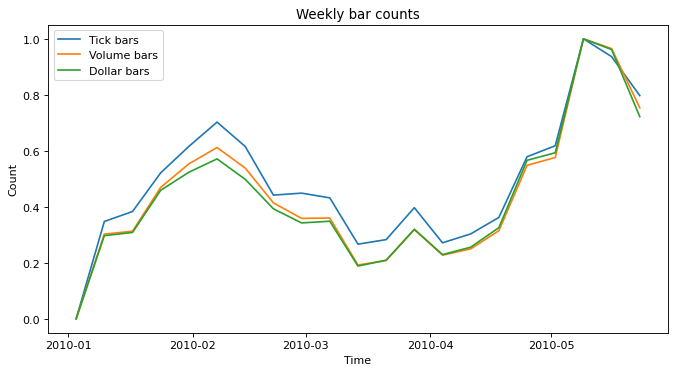

In [51]:
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(tick_bar_counts.index, tick_bar_counts, label='Tick bars')
plt.plot(volume_bar_counts.index, volume_bar_counts, label='Volume bars')
plt.plot(dollar_bar_counts.index, dollar_bar_counts, label='Dollar bars')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Weekly bar counts')
plt.legend()
plt.show()

In [52]:
print(f'Std of tick bar counts: \t{tick_bar_counts.std()}')
print(f'Std of volume bar counts:\t{volume_bar_counts.std()}')
print(f'Std of dollar bar counts:\t{dollar_bar_counts.std()}')

Std of tick bar counts: 	0.23824136299272772
Std of volume bar counts:	0.24901145668148347
Std of dollar bar counts:	0.2455028825034393


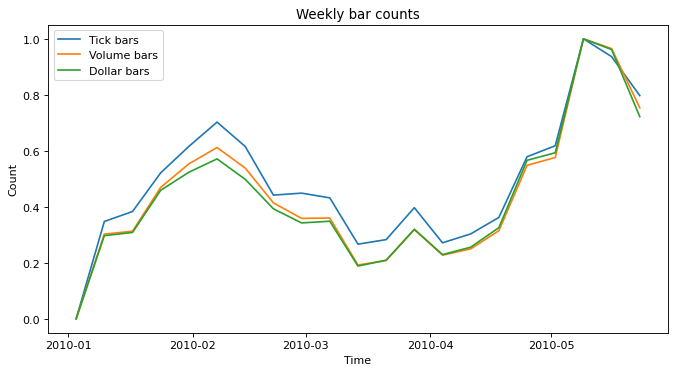

In [53]:
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(tick_bar_counts.index, tick_bar_counts, label='Tick bars')
plt.plot(volume_bar_counts.index, volume_bar_counts, label='Volume bars')
plt.plot(dollar_bar_counts.index, dollar_bar_counts, label='Dollar bars')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Weekly bar counts')
plt.legend()
plt.show()

We may also summarize the spreads of the counts using their standard deviation.

In [54]:
print(f'Std of tick bar counts: \t{tick_bar_counts.std()}')
print(f'Std of volume bar counts:\t{volume_bar_counts.std()}')
print(f'Std of dollar bar counts:\t{dollar_bar_counts.std()}')

Std of tick bar counts: 	0.23824136299272772
Std of volume bar counts:	0.24901145668148347
Std of dollar bar counts:	0.2455028825034393


## <u>Task 2</u>
Analyze the weekly counts, as well as their spread. Does the result match your expectations?

**Bonus:** Change the numbers of bars sampled in the beginning of the notebook. How does this affect the result above? Is this in line with your expectations?

## Returns

As a final comparison, let's look at the distribution of log-returns calculated using the different sampling methods.

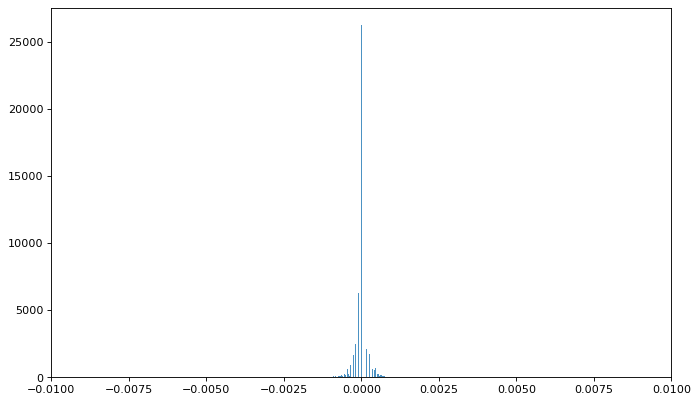

In [55]:
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(tick_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((-0.01,0.01))
plt.show()

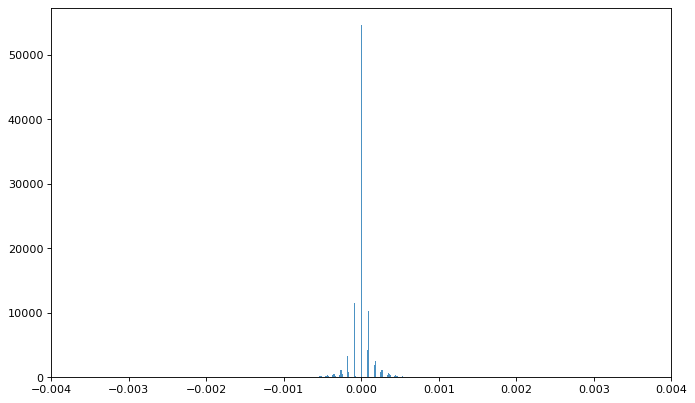

In [56]:
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(volume_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((-0.004,0.004))
plt.show()

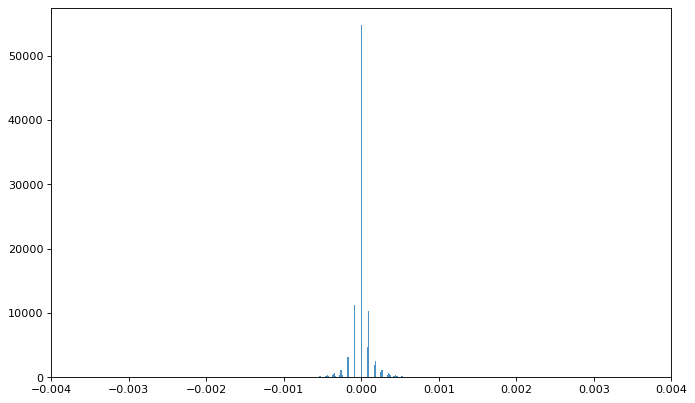

In [57]:
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(dollar_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((-0.004,0.004))
plt.show()

Aside from plotting, we can also perform a normality test (D’Agostino-Pearson) on the log returns.

In [58]:
# Check and resolve duplicate indices
for df_name, df in [('tick_bars', tick_bars), ('volume_bars', volume_bars), ('dollar_bars', dollar_bars)]:
    if df.index.duplicated().any():
        print(f"Duplicate indices found in {df_name}, removing duplicates.")
        df = df[~df.index.duplicated(keep='first')]

# Reset index to avoid alignment issues (optional)
tick_bars = tick_bars.reset_index(drop=True)
volume_bars = volume_bars.reset_index(drop=True)
dollar_bars = dollar_bars.reset_index(drop=True)

# Replace infinities and drop NaNs
#tick_bars.loc[:, 'price'] = tick_bars['price'].replace([np.inf, -np.inf], np.nan).dropna()
#volume_bars.loc[:, 'price'] = volume_bars['price'].replace([np.inf, -np.inf], np.nan).dropna()
#dollar_bars.loc[:, 'price'] = dollar_bars['price'].replace([np.inf, -np.inf], np.nan).dropna()


Duplicate indices found in tick_bars, removing duplicates.
Duplicate indices found in volume_bars, removing duplicates.
Duplicate indices found in dollar_bars, removing duplicates.


In [59]:
tick_bars = tick_bars.dropna(subset=['price'])
volume_bars = volume_bars.dropna(subset=['price'])
dollar_bars = dollar_bars.dropna(subset=['price'])


In [60]:
tick_bars_normaltest = normaltest(tick_bars['price'])
volume_bars_normaltest = normaltest(volume_bars['price'])
dollar_bars_normaltest = normaltest(dollar_bars['price'])

print(f'Tick bars\nStatistic: {tick_bars_normaltest.statistic}\np-value: {tick_bars_normaltest.pvalue}\n')
print(f'Volume bars\nStatistic: {volume_bars_normaltest.statistic}\np-value: {volume_bars_normaltest.pvalue}\n')
print(f'Dollar bars\nStatistic: {dollar_bars_normaltest.statistic}\np-value: {dollar_bars_normaltest.pvalue}')

Tick bars
Statistic: 28773.376332632335
p-value: 0.0

Volume bars
Statistic: 19520.794190811754
p-value: 0.0

Dollar bars
Statistic: 18647.602868894803
p-value: 0.0


If you don't trust these, you can employ e.g. the Shapiro-Wilk normality test:

In [61]:
tick_bars_normaltest = shapiro(tick_bars['price'])
volume_bars_normaltest = shapiro(volume_bars['price'])
dollar_bars_normaltest = shapiro(dollar_bars['price'])

print(f'Tick bars\nStatistic: {tick_bars_normaltest.statistic}\np-value: {tick_bars_normaltest.pvalue}\n')
print(f'Volume bars\nStatistic: {volume_bars_normaltest.statistic}\np-value: {volume_bars_normaltest.pvalue}\n')
print(f'Dollar bars\nStatistic: {dollar_bars_normaltest.statistic}\np-value: {dollar_bars_normaltest.pvalue}')

Tick bars
Statistic: 0.9720394456343258
p-value: 2.153589024249082e-84

Volume bars
Statistic: 0.971325549051821
p-value: 4.613209617777989e-79

Dollar bars
Statistic: 0.9710663162327975
p-value: 2.7760263260071994e-79


c:\Users\Teemu\.conda\envs\dle\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 127087.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Teemu\.conda\envs\dle\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 91383.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Teemu\.conda\envs\dle\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 91455.
  res = hypotest_fun_out(*samples, **kwds)


## <u>Task 3</u>

Interpret the distributions and the results of the test above. What do the results of the test say about the sampling method? What are the implications of the result on financial modeling in general?

**5 credit version of the course:** Uncomment the lines *plt.xlim((a,b))* in the histogram cells above. Play around with the limits and explore regions further away from the origin. Interpret the results.

The following resources might help in interpreting the normality test result:
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
* https://www.investopedia.com/terms/p/p-value.asp

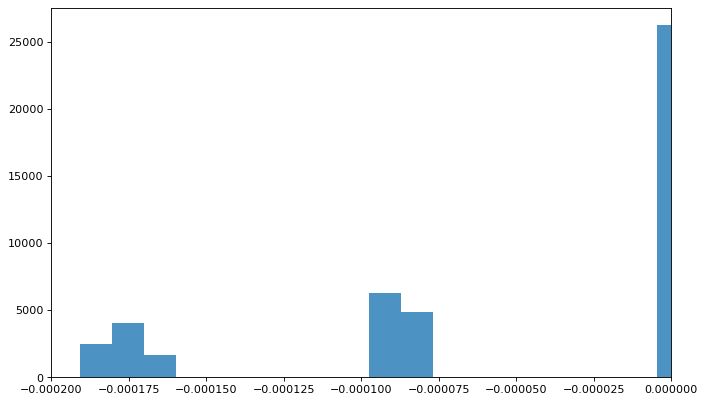

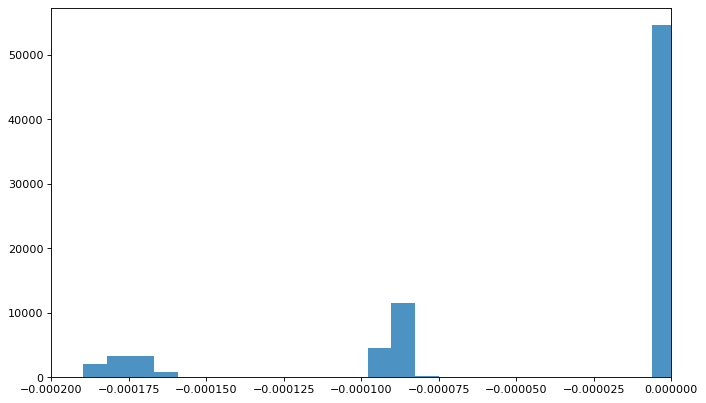

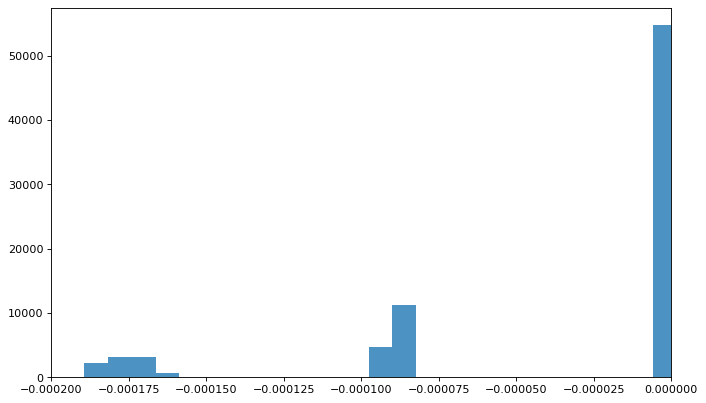

In [68]:
a = -0.0002
b = 0.0000

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(tick_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((a, b))
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(volume_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((a, b))
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(dollar_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((a, b))
plt.show()

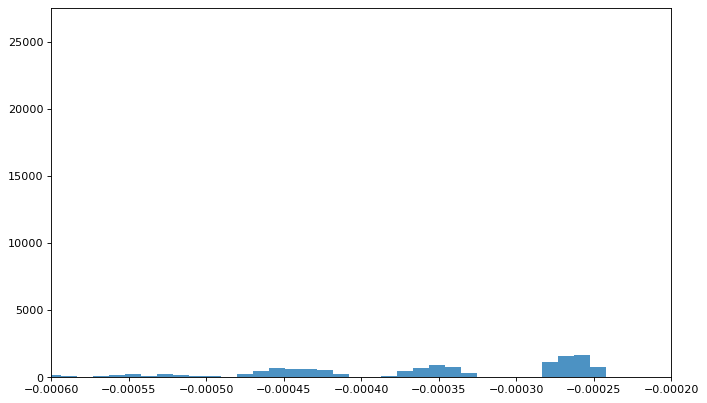

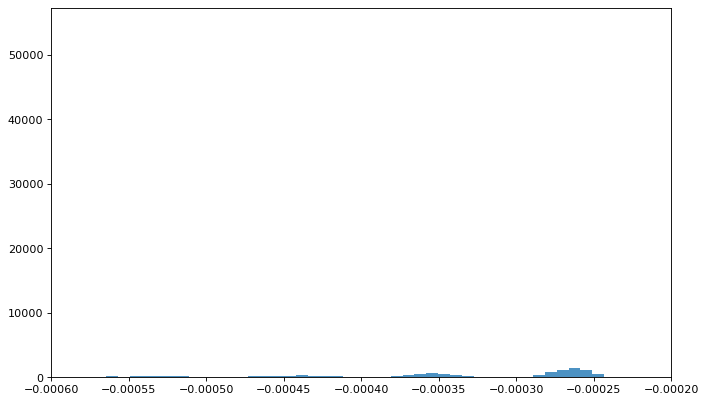

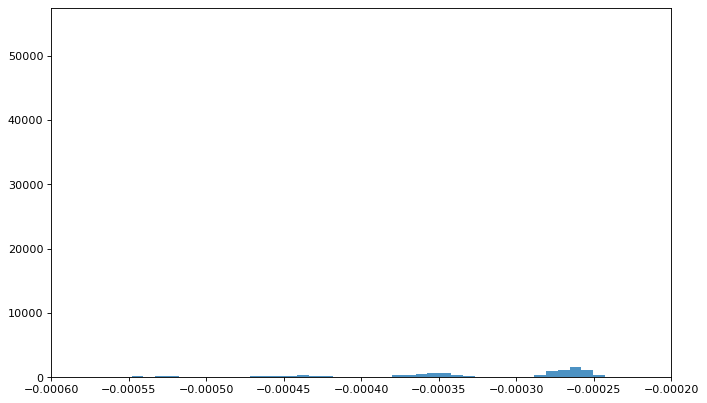

In [71]:
a = -0.0006
b = -0.0002

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(tick_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((a, b))
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(volume_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((a, b))
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(np.diff(np.log(dollar_bars['price'])), bins='auto', density=True, alpha=0.8)
plt.xlim((a, b))
plt.show()